## Introduction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Importing library in order to see the progress bar
from tqdm.notebook import tnrange, tqdm_notebook
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('cleaned_twitter_data.csv')

In [3]:
df.shape

(1581247, 13)

In [4]:
df.head(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
0,0,_TheSpecialOne_,awww thats a bummer you shoulda got david ca...,switchfoot,NaN,;d,4,6,2009,22,19,45,Monday
1,0,scotthamilton,is upset that he cant update his facebook by t...,NaN,NaN,None,4,6,2009,22,19,49,Monday


In [5]:
df.isna().sum()

Sentiment          0
User               0
Tweet              0
Tagging       854040
Hashtags     1546447
Emojis             0
Month              0
Day                0
Year               0
Hour               0
Minutes            0
Seconds            0
DayOfWeek          0
dtype: int64

In [6]:
df['Tagging'] = df['Tagging'].fillna('None')
df['Hashtags'] = df['Hashtags'].fillna('None')

In [7]:
df.isna().sum()

Sentiment    0
User         0
Tweet        0
Tagging      0
Hashtags     0
Emojis       0
Month        0
Day          0
Year         0
Hour         0
Minutes      0
Seconds      0
DayOfWeek    0
dtype: int64

In [8]:
df.shape

(1581247, 13)

### Taking a Sample data

In [9]:
# copying 10% of data
df_chunk = df.sample(frac=0.05).copy()

In [10]:
df_chunk.shape

(79062, 13)

In [11]:
df_chunk['Sentiment'].value_counts().sum()

79062

In [12]:
df_chunk['Sentiment'].value_counts()

0    39687
1    39375
Name: Sentiment, dtype: int64

In [13]:
df_chunk = df_chunk.reset_index(drop=True)

In [14]:
df_chunk.sample(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
32714,0,caseysevenfold,i know and it makes me sad,chlostick,None,None,6,17,2009,5,15,24,Wednesday
15566,0,JRoberson88,i know i had work and couldnt come down,mdwaterfront,None,None,4,19,2009,12,10,42,Sunday


### working with sample data

In [15]:
# plt.figure(figsize=(10,4))
# df_chunk['Sentiment'].value_counts().plot(kind='bar', rot=0, color=['#FF7F0E', '#3685BC'])
# plt.title("Target Distirbution")
# plt.xlabel("Sentiment")
# plt.ylabel("Count")

# plt.show()

---
### Data Wrangling

In [16]:
# splitting our data into train and test sets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
df_chunk.head(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
0,0,Femikneesm,finally watched hedwig the angry inch what a...,None,None,None,6,17,2009,0,25,29,Wednesday
1,1,scottcompete,oh yeah you have too much time on your hands,jonmichaeli,None,None,5,29,2009,15,5,22,Friday


In [18]:
X = pd.DataFrame(df_chunk['Tweet']) # indep
y = df_chunk["Sentiment"] # dep

In [19]:
X.head()

,Tweet
0,finally watched hedwig the angry inch what a...
1,oh yeah you have too much time on your hands
2,don giovanna and now norma in june i dont ca...
3,reading inspirational quotes from my pocket pa...
4,am accountants meetinglate as usual


#### Check the shape of the Data

In [20]:
X.shape

(79062, 1)

In [21]:
y.shape

(79062,)

In [22]:
# Test set 20 percent
X_rem, X_test, y_rem, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=1)

In [23]:
# Splitting the remainder in two chunks
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size = 0.3, stratify=y_rem, random_state=1)

In [24]:
print(f'Shape of X-test set: {X_test.shape}')
print(f'Shape of X remainder set: {X_rem.shape}')

print(f'Shape of validation set: {X_val.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of X-test set: (15813, 1)
Shape of X remainder set: (63249, 1)
Shape of validation set: (18975, 1)
Shape of train set: (44274, 1)


Our final proportions end up being
* Test Set: *0.2*
* Validation Set:  0.8 * 0.3 = *0.24*
* Training Set: 0.8 * 0.7 = *0.56*

In [25]:
bagofwords_vector = CountVectorizer(stop_words="english")

bagofwords_vector.fit(X_train['Tweet'])

X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [26]:
X_train_transform

<44274x34918 sparse matrix of type '<class 'numpy.int64'>'
	with 274174 stored elements in Compressed Sparse Row format>

In [27]:
len(bagofwords_vector.get_feature_names_out())

34918

In [28]:
np.mean(X_train_transform.toarray().sum(axis=0))


8.026146972907956

Based on the mean we try min_df of ~8

In [29]:
bagofwords_vector = CountVectorizer(stop_words="english", min_df=8)

bagofwords_vector.fit(X_train['Tweet'])

X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [30]:
X_train_transform

<44274x3829 sparse matrix of type '<class 'numpy.int64'>'
	with 222673 stored elements in Compressed Sparse Row format>

In [31]:
len(bagofwords_vector.get_feature_names_out())

3829

In [32]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
my_df = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_train_transform.toarray())
display(my_df)

,aaah,aaron,ability,abit,able,absolute,absolutely,abt,ac,accept,...,yucky,yum,yummy,yup,zac,zealand,zero,zombies,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
my_df.shape[0] == X_train.shape[0]

True

In [34]:
import nltk
from nltk.stem import WordNetLemmatizer

# Let's test it out
# stemmer = nltk.stem.PorterStemmer()

In [35]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [36]:
lemmatizer = WordNetLemmatizer()

# bagofwords_vector = CountVectorizer(stop_words="english",
#                                     tokenizer = lambda x: [stemmer.stem(i) for i in x.split(' ')],
#                                     min_df=1000)

bagofwords_vector = CountVectorizer(stop_words="english",
                                    tokenizer=lambda x: [lemmatizer.lemmatize(i) for i in x.split()], min_df=8)
# 2. Fit
bagofwords_vector.fit(X_train['Tweet'])

CountVectorizer(min_df=8, stop_words='english',
                tokenizer=<function <lambda> at 0x000001A484A1B250>)

In [37]:
# 3. Transform - tokenize (split to words) & count for each sentence how many times each occurs
X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [38]:
X_train_transform

<44274x3677 sparse matrix of type '<class 'numpy.int64'>'
	with 233987 stored elements in Compressed Sparse Row format>

In [39]:
X_val_transform

<18975x3677 sparse matrix of type '<class 'numpy.int64'>'
	with 100283 stored elements in Compressed Sparse Row format>

In [40]:
X_test_transform

<15813x3677 sparse matrix of type '<class 'numpy.int64'>'
	with 83449 stored elements in Compressed Sparse Row format>

15813 features to 4668 feature

In [41]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_train_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_train_transform.toarray())
X_train_df_vect

,aaah,aaron,ab,ability,abit,able,absolute,absolutely,abt,ac,...,yum,yummy,yup,z,zac,zealand,zero,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_val_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_val_transform.toarray())
X_val_df_vect

,aaah,aaron,ab,ability,abit,able,absolute,absolutely,abt,ac,...,yum,yummy,yup,z,zac,zealand,zero,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18971,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
words = bagofwords_vector.get_feature_names_out()
some_indices = range(1, 3739, round(3739/10))
samples = [words[i] for i in some_indices]
print(samples)

['aaron', 'bound', 'cum', 'favourite', 'high', 'listen', 'oldest', 'remix', 'stalker', 'ughh']


In [44]:
counts = np.array(X_train_transform[:, some_indices].sum(axis = 0))

display(pd.DataFrame({"total_corpus_count": counts[0]}, index=samples).T)

,aaron,bound,cum,favourite,high,listen,oldest,remix,stalker,ughh
total_corpus_count,8,11,13,38,112,95,10,11,11,11


In [45]:
bagofwords_vector.get_feature_names_out()

array(['aaah', 'aaron', 'ab', ..., 'zombie', 'zone', 'zoo'], dtype=object)

In [46]:
word_counts = pd.DataFrame(
    {"counts": X_train_transform.toarray().sum(axis=0)},
    index=bagofwords_vector.get_feature_names_out()
).sort_values("counts", ascending=False)

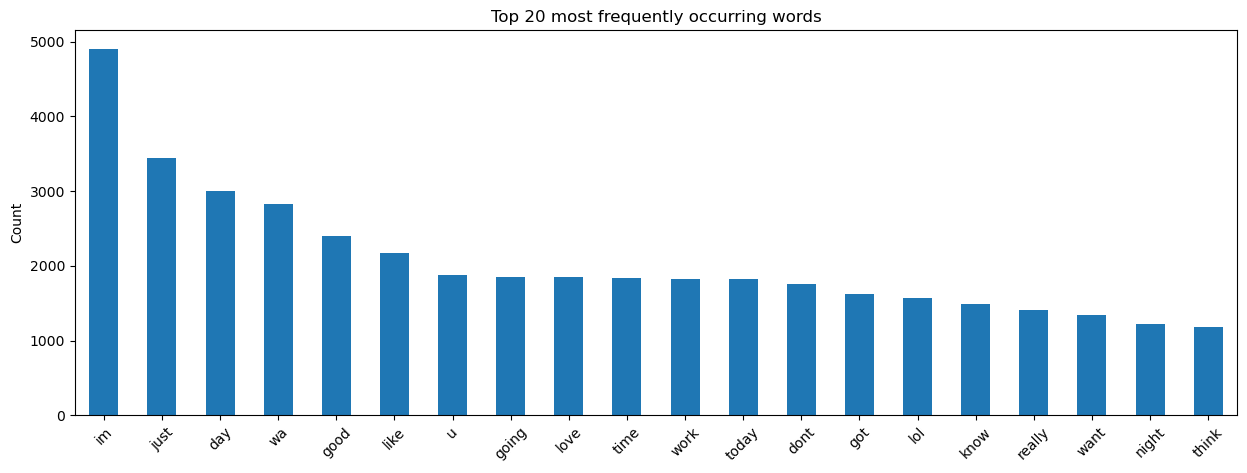

In [47]:
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Modeling

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
# Initializing Scale
scaler = MinMaxScaler()

# Fitting scale
scaler.fit(X_train_df_vect)

# Transform scale
X_train_scaled = scaler.transform(X_train_df_vect)
X_validation_scaled = scaler.transform(X_val_df_vect)

In [50]:
# instantiate model
logreg_model = LogisticRegression(max_iter=100000, random_state=1)

# fit the model
logreg_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=100000, random_state=1)

In [51]:
# Training and test score
print(f"Train score: {logreg_model.score(X_train_scaled, y_train)}")
print(f"Validation score: {logreg_model.score(X_validation_scaled, y_val)}")

Train score: 0.7851786601617202
Validation score: 0.7382872200263505


In [53]:
logreg_model.coef_[0]

array([-0.17643524,  0.47336389,  0.40567283, ..., -0.2204286 ,
        0.56477455,  0.59501766])

In [54]:
word_coefficients = pd.DataFrame(
    {"coefficients": logreg_model.coef_[0]},
    index=bagofwords_vector.get_feature_names_out()
).sort_values("coefficients", ascending=False)

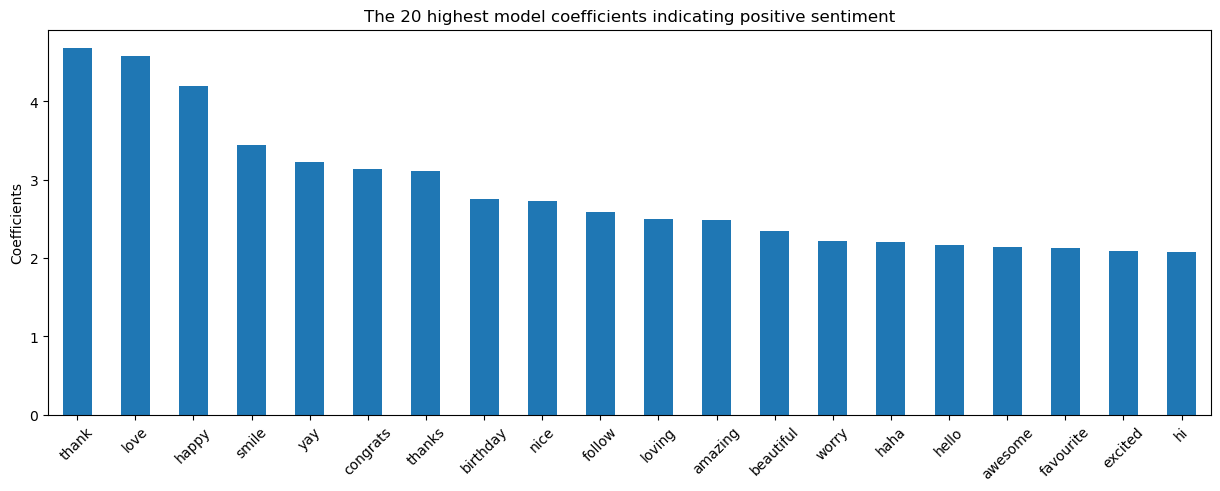

In [55]:
word_coefficients.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

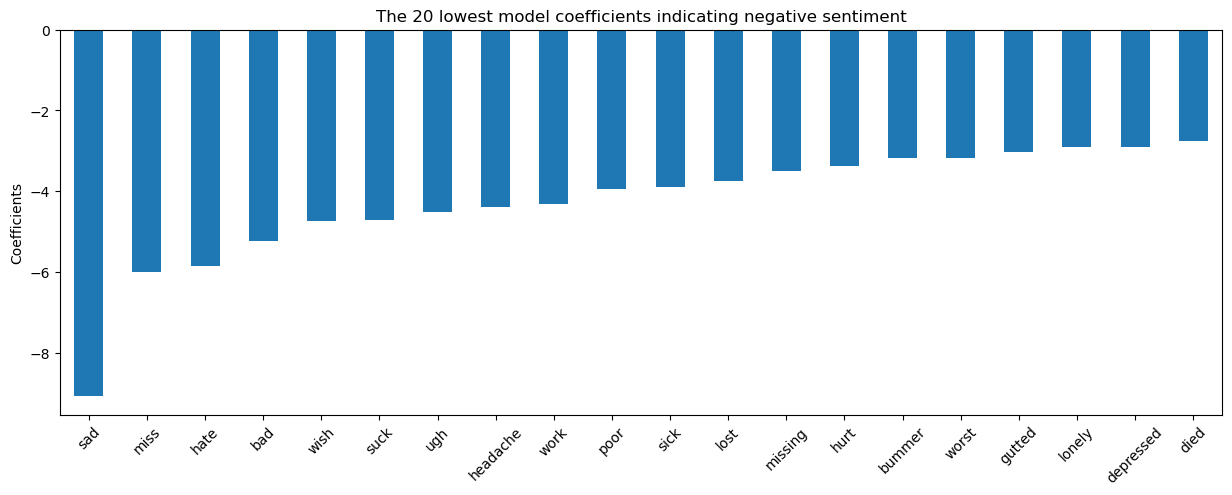

In [56]:
word_coefficients.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [57]:
word_coefficients

,coefficients
thank,4.681985
love,4.575503
happy,4.193380
smile,3.439638
yay,3.222060
...,...
wish,-4.751915
bad,-5.245036
hate,-5.855297
miss,-6.003102


In [58]:
# instantiate model
logreg = LogisticRegression(solver='lbfgs', max_iter=100000, random_state=1)# saga different regularization and try out

# fit the model
logreg.fit(X_train_transform, y_train)
# Training and test score
print(f"Train score: {logreg.score(X_train_scaled, y_train)}")
print(f"Validation score: {logreg.score(X_validation_scaled, y_val)}")

Train score: 0.7660477932872566
Validation score: 0.7140974967061924


In [59]:
%%time
# instantiate model
logreg = LogisticRegression(solver='saga', max_iter=100000, random_state=1)# saga different regularization and try out

# fit the model
logreg.fit(X_train_transform, y_train)
# Training and test score
print(f"Train score: {logreg.score(X_train_scaled, y_train)}")
print(f"Validation score: {logreg.score(X_validation_scaled, y_val)}")

Train score: 0.7659574468085106
Validation score: 0.71399209486166
CPU times: total: 5.67 s
Wall time: 3.82 s


In [60]:
%%time
# instantiate model
logreg = LogisticRegression(solver='liblinear', max_iter=100000, random_state=1)# saga different regularization and try out

# fit the model
logreg.fit(X_train_transform, y_train)
# Training and test score
print(f"Train score: {logreg.score(X_train_scaled, y_train)}")
print(f"Validation score: {logreg.score(X_validation_scaled, y_val)}")

Train score: 0.7659800334281971
Validation score: 0.7140447957839262
CPU times: total: 2.28 s
Wall time: 733 ms


In [61]:
# estimators = [('reduce_dim', PCA()),
#             ('logreg_model', LogisticRegression())]
estimators = [
    ('reduce_dim', PCA()),
    ('logreg_model', LogisticRegression())
]
pipe = Pipeline(estimators)

In [100]:
# params = {
#     'reduce_dim__n_components': [1, 10],
#     'logreg_model__solver': ['lbfgs','saga', 'liblinear']
# }

# grid_search_gbc = GridSearchCV(pipe, param_grid=params, cv = 5, n_jobs = -1, verbose = 1)
# grid_search_gbc.fit(X_train_scaled, y_train)
# Wrap grid_search_gbc in tqdm to show progress bar
# grid_search_gbc = tqdm(grid_search_gbc, total=len(grid_search_gbc.cv))

In [95]:
# grid_search_gbc.fit(X_train_transform.todense(), y_train)

In [46]:
# # best score
# print(f"best score: {grid_search.best_score_}")

# # best parameters
# print(f"best parameters: {grid_search.best_params_}")

In [59]:
# setting array
cross_validation_scores = []

c_range = np.array([0.001, 0.01, 0.1, 0.5, 1, 10, 30, 60, 80, 100])

# Do some cross validation
for c in tqdm_notebook(c_range):
    Logreg_model_fold = LogisticRegression(C=c, solver='lbfgs', max_iter=10000, random_state=1)
    cv_score = np.mean(cross_val_score(Logreg_model_fold, X_train_transform, y_train, cv = 5, n_jobs=-1))
    cross_validation_scores.append(cv_score)
    
    print(f'C: {c}')
    print(f'cv_score {cv_score}')

  0%|          | 0/10 [00:00<?, ?it/s]

C: 0.001
cv_score 0.7014014746440029
C: 0.01
cv_score 0.7359824393538583
C: 0.1
cv_score 0.7539370743513255
C: 0.5
cv_score 0.7534305172510836
C: 1.0
cv_score 0.7501998086339843
C: 10.0
cv_score 0.7354533686047166
C: 30.0
cv_score 0.7299150109754038
C: 60.0
cv_score 0.7269882366184499
C: 80.0
cv_score 0.725772499577869
C: 100.0
cv_score 0.7251533742331289


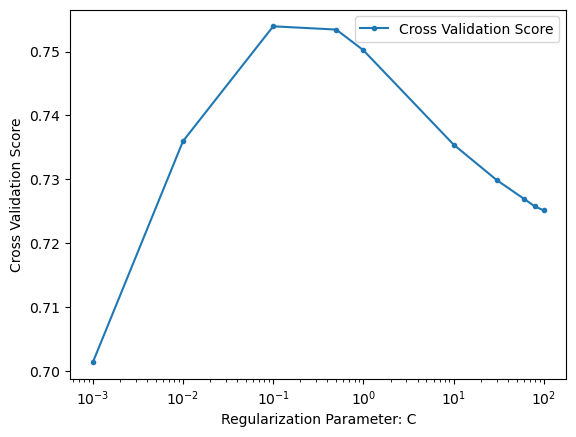

In [60]:
plt.figure()
plt.plot(c_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.show()